# Librerías

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

import athena_utils as athena

In [169]:
projects_id= 72

# Querys

In [ ]:
def ejecutar_queries_paralelo(queries_dict, max_workers=5):
    """
    Ejecuta múltiples queries de Athena en paralelo.
    
    Args:
        queries_dict (dict): Diccionario donde la clave es el nombre identificador 
                            y el valor es la query SQL
                            Ejemplo: {'cancelaciones': query1, 'asistencias': query2}
        max_workers (int): Número máximo de threads paralelos (default: 5)
    
    Returns:
        dict: Diccionario con los DataFrames resultantes
              Ejemplo: {'cancelaciones': df1, 'asistencias': df2}
    """
    results = {}
    errors = {}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las queries en paralelo
        futures = {
            executor.submit(athena.run_athena_query_auto, query, name): name 
            for name, query in queries_dict.items()
        }
        
        # Recoger resultados según vayan terminando
        for future in as_completed(futures):
            query_name = futures[future]
            try:
                df = future.result()
                results[query_name] = df
                print(f"✅ {query_name}: {len(df)} filas obtenidas")
            except Exception as e:
                errors[query_name] = str(e)
                print(f"❌ {query_name}: Error - {e}")
    
    # Reportar resumen
    print(f"\n📊 Resumen: {len(results)}/{len(queries_dict)} queries completadas exitosamente")
    
    if errors:
        print(f"⚠️  Queries con error: {list(errors.keys())}")
    
    return results

In [170]:
query_cancelaciones= f'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS org_names
    FROM datalake.project_organization_association poa
    JOIN datalake.organizations o ON poa.organization_id = o.id
    GROUP BY poa.project_id
),
cte_ProgramType AS (
    SELECT
        ppta.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS program_types
    FROM datalake.project_program_type_association ppta
    JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
    GROUP BY ppta.project_id
),
base AS (
    SELECT
        DISTINCT
        p.id AS projectsID,
        p.name AS "Proyecto",
        COALESCE(p.type, 'B2C') AS "Canal",
        pt.program_types AS "Tipo de programa",
        o.org_names AS "Organización",
        (CASE WHEN ee.institution IS NULL THEN ei.name ELSE ee.institution END) AS institucion,
        (CASE WHEN ee.group_section IS NULL THEN rr.college_group ELSE ee.group_section END) AS seccion,
        ee.career AS career,
        rr.id AS room,
        rr.name AS "Room Name",
        CONCAT('https://backoffice.crackthecode.la/dashboard/rooms/', CAST(rr.id AS VARCHAR)) AS "Link Room",
        rs.id AS sesionID,
        rs.session_number AS sesion,
        ee.grade AS grado,
        (CASE WHEN rs.cancellation_reason_id IS NULL THEN 36 ELSE rs.cancellation_reason_id END) AS reasonID,
        (CASE WHEN rc.name IS NULL THEN 'N/A' ELSE rc.name END) AS Motivo,
        rs.start_date AS "Fecha",
        rs.start_time AS Hora,
        SUBSTR(rs.start_time, 1, 2) AS "Hora Agrupada",
        DATE_TRUNC('week', rs.start_date) AS ordenSemana,
        CONCAT(
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date), '%d/%m'),
            '-',
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date) + INTERVAL '6' DAY, '%d/%m')
        ) AS semana,
        DATE_FORMAT(rs.start_date, '%W') AS dia,
        rs.state AS state,
        rs.risk_cancellation AS Riesgo,
        CONCAT(au.last_name, ', ', au.first_name) AS profesor
    FROM
        datalake.room_roomsessions rs
        LEFT JOIN datalake.room_room rr ON rs.room_id = rr.id
        JOIN datalake.enrollment_enrolment ee ON rr.id = ee.room_id AND ee.b2b_project_id IS NOT NULL
        LEFT JOIN datalake.projects p ON (ee.b2b_project_id = p.id OR p.id = rr.project_b2b_id)
        LEFT JOIN cte_Organization o ON p.id = o.project_id
        LEFT JOIN cte_ProgramType pt ON p.id = pt.project_id
        LEFT JOIN datalake.account_user au ON rr.teacher_id = au.id
        LEFT JOIN datalake.catalog_reasonsessioncancellation rc ON (
            (CASE WHEN (rs.state = 'false' AND rs.cancellation_reason_id IS NULL) THEN 36 ELSE rs.cancellation_reason_id END) = rc.id
        )
        LEFT JOIN datalake.educational_institution ei ON ei.id = rr.educational_institution_id
    ORDER BY
        DATE_TRUNC('week', rs.start_date) ASC
)
SELECT *
FROM base
WHERE
    NOT (state = 'false' AND projectsID IN (19, 14) AND (("Fecha" BETWEEN DATE '2024-06-17' AND DATE '2024-07-05') OR ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14')))
    AND
    NOT (state = 'false' AND projectsID IN (47, 48, 56) AND ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14'))
    AND
    (reasonID NOT IN (33, 34, 35) OR reasonID IS NULL)
    
    and projectsID IN ({projects_id})
    
    ;


'''

In [171]:
query_asistencias=f'''

SELECT
*
FROM
asistencia_alumnos

where 
b2b_project_id IN ({projects_id})

'''

In [172]:
query_cuestionarios = f''' 

SELECT DISTINCT
     me.moodle_id moodle_user_id
   , 'Moodle' origen
   , ss.id student_id
   , ee.institution educative_institution
   , ee.grade grade
   , concat(ee.grade,'+', ee.group_section) grade_section
   , ee.career career
   , ee.educational_level educational_level
   , DATE_DIFF('year', ss.birthdate, p.operative_start_date) age 
   , ss.gender genero
   , p.id project_id
   , p.name project_name
   , ce.course_id moodle_course_id
   , rr.id room_id
   , ce.unique_id evaluation_unique_id
   , ce.name evaluation_name
   , ceq.name question_name
   , ceq.tag tag_question
   , ceq.question_id question_id
   , ceq.question_name question
   , cer.answer answer
   , cer.right_answer right_answer
   , ce.tag AS tipo_test

   FROM
   moodle_enrollment me
   LEFT JOIN moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   LEFT JOIN moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   LEFT JOIN moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
   INNER JOIN room_room rr ON (rr.course_mdl_id = me.course_id)
   LEFT JOIN student_student ss ON (ss.user_mdl_id = me.moodle_id)
   LEFT JOIN room_room_students rrs ON ((rrs.student_id = ss.id) AND (rrs.room_id = rr.id))
   LEFT JOIN enrollment_enrolment ee ON (((ee.group_id = rr.group_id) OR (ee.room_id = rr.id)) AND (ee.student_id = ss.id) AND (ee.state <> 'cancel') AND (ee.state <> 'inactive'))
   LEFT JOIN projects p ON (p.id = ee.b2b_project_id)
   
   WHERE (p.id in ({projects_id}) and (me.role = 'student'))



'''

In [173]:
query_alumnos = f'''
select distinct
    p.id as Proyecto,
    ss.id as ID, 
    concat(ss.last_name, ', ', ss.first_name) as Nombre_Completo,
    ss.email as Email,
    ss.phone_number as Telefono,
    ss.doc_type as tipo_documento,
    ss.doc_number as documento,
    ee.institution as Institucion,
    ee.grade as grado,
    ee.group_section as seccion,
    ee.room_id as Salon,
    case 
        when ss.gender='male' then 'Hombres'
        when ss.gender='female' then 'Mujeres'
        else 'Indefinido' end as Genero,
    DATE_DIFF('year', ss.birthdate, p.operative_start_date) as Edad,
    case when ((ee.state <> 'cancel') and (ee.state <> 'inactive')) then 'Activo' else 'Inactivo' end as Status,
	COALESCE(MAX(CASE WHEN ceq.tag = 'estrato_socioeconomico' THEN cer.answer END), 'Sin respuesta') AS estrato_socioeconomico,
	COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'etnia' THEN cer.answer END) FILTER (WHERE ceq.tag = 'etnia'), '|'), 'Sin respuesta') AS etnia,
    CASE 
        WHEN SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) = 0 THEN '1- Solo Desktop'
        WHEN SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) = 0 THEN '5- Solo Mobile'
        WHEN (SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '2- 80% Desktop'
        WHEN (SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '4- 80% Mobile'
        ELSE '3- Mixto'
        END AS dispositivo
	
from
    datalake.enrollment_enrolment ee
    left join datalake.student_student ss on ss.id=ee.student_id
    left join datalake.projects p on p.id=ee.b2b_project_id
	left join datalake.moodle_enrollment me on me.moodle_id=ss.user_mdl_id
	LEFT JOIN datalake.moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   	LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   	LEFT JOIN datalake.moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
    LEFT JOIN datalake.moodle_session_device msd ON msd.userid=ss.user_mdl_id and msd.ip is not null

where
    p.id in ({projects_id})
    and ee.state='done'

group by
	p.id,
    ss.id,
    ss.last_name,
    ss.first_name,
    ss.email,
    ss.phone_number,
    ss.doc_type,
    ss.doc_number,
    ee.institution,
    ee.grade,
    ee.group_section,
    ee.room_id,
    ss.gender,
    ss.birthdate,
    p.operative_start_date,
    ee.state
'''

In [174]:
# Preparar queries
queries = {
    'cancelaciones': query_cancelaciones,
    'asistencias': query_asistencias,
    'cuestionarios': query_cuestionarios,
    'alumnos': query_alumnos
}

# Ejecutar en paralelo
print("🚀 Iniciando ejecución de queries en paralelo...\n")
dataframes = ejecutar_queries_paralelo(queries)

🚀 Iniciando ejecución de queries en paralelo...

✅ cancelaciones: 8972 filas obtenidas
✅ asistencias: 173356 filas obtenidas
✅ alumnos: 8035 filas obtenidas
✅ cuestionarios: 9852429 filas obtenidas

📊 Resumen: 4/4 queries completadas exitosamente


In [175]:
# Acceder a los resultados
df_cancelaciones = dataframes.get('cancelaciones')
df_asistencias = dataframes.get('asistencias')
df_cuestionarios = dataframes.get('cuestionarios')
df_alumnos=dataframes.get('alumnos')

## 📊 Análisis de Distribuciones Demográficas

## Funciones

In [176]:
def truncar_texto(texto, max_chars=25):
    """Acorta texto largo agregando '...' """
    texto_str = str(texto)
    if len(texto_str) > max_chars:
        return texto_str[:max_chars-3] + '...'
    return texto_str

In [177]:
def crear_grafico_distribucion(
    df_distribucion,
    col_categoria,
    col_cantidad,
    titulo_grafico,
    label_y,
    titulo_tabla='Datos Numéricos',
    colormap='Blues',
    ancho_tabla=None,
    tamaño_figura=None,
    tamaño_fuente_tabla=None,
    truncar_categorias=True,  # Cambiar a True por defecto
    max_chars_categoria=None  # Ahora se calcula automáticamente
):
    """
    Crea un gráfico de distribución con barras horizontales y tabla de datos.
    Ajusta automáticamente el tamaño según la longitud de las categorías.
    """
    # Análisis de longitud de categorías
    max_len = df_distribucion[col_categoria].astype(str).str.len().max()
    
    # Ajustar tamaño de figura automáticamente
    if tamaño_figura is None:
        if max_len > 30:
            tamaño_figura = (15, 6)
        elif max_len > 20:
            tamaño_figura = (14, 5.5)
        else:
            tamaño_figura = (12, 5)
    
    # Invertir para mostrar de arriba a abajo
    dist_invertido = df_distribucion.iloc[::-1].copy()
    
    # Crear figura
    fig = plt.figure(figsize=tamaño_figura, constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.15)
    
    # --- SUBPLOT 1: Gráfico de Barras ---
    ax_bar = fig.add_subplot(gs[0])
    
    n_categorias = len(dist_invertido)
    
    if isinstance(colormap, list):
        # Si es lista, usarla directamente (tomar solo los necesarios)
        colores = colormap[:n_categorias]
    else:
        # Si es string (nombre de colormap), crear degradado
        colores = plt.colormaps[colormap](np.linspace(0.4, 0.9, n_categorias))
    
    bars = ax_bar.barh(
        dist_invertido[col_categoria], 
        dist_invertido[col_cantidad],
        color=colores,
        edgecolor='white',
        linewidth=2.5
    )
    
    # Agregar etiquetas
    for bar, cantidad in zip(bars, dist_invertido[col_cantidad]):
        porcentaje = (cantidad / dist_invertido[col_cantidad].sum()) * 100
        ax_bar.text(
            cantidad + (dist_invertido[col_cantidad].max() * 0.02),
            bar.get_y() + bar.get_height()/2,
            f'{cantidad} ({porcentaje:.1f}%)',
            va='center',
            fontsize=11,
            weight='bold',
            color='#2E3F5F'
        )
    
    # Estilo del gráfico
    ax_bar.set_ylabel(label_y, fontsize=11, weight='bold', color='#2E3F5F')
    ax_bar.set_title(titulo_grafico, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    ax_bar.grid(False)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_color('#CCCCCC')
    ax_bar.spines['bottom'].set_visible(False)
    ax_bar.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_bar.tick_params(axis='y', colors='#2E3F5F', labelsize=9 if max_len > 20 else 10)
    ax_bar.set_xlim(0, dist_invertido[col_cantidad].max() * 1.18)
    
    # --- SUBPLOT 2: Tabla ---
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    
    # Calcular anchos basados en el nombre de las columnas
    len_col_categoria = len(col_categoria)
    len_col_cantidad = len(col_cantidad)
    len_porcentaje = len('Porcentaje')

    # Calcular proporciones
    total_chars = len_col_categoria + len_col_cantidad + len_porcentaje

    if ancho_tabla is None:
        # Calcular anchos proporcionales REALES según el nombre de las columnas
        # SIN límites min/max para que el nombre entre completo
        ancho_cat = len_col_categoria / total_chars
        ancho_cant = len_col_cantidad / total_chars
        ancho_porc = len_porcentaje / total_chars
        
        ancho_tabla = [ancho_cat, ancho_cant, ancho_porc]

    
    # Calcular máximo de caracteres permitidos basado en el ancho
    if max_chars_categoria is None:
        # Estimar caracteres según ancho de columna (aproximado)
        max_chars_categoria = int(ancho_tabla[0] * 50)  # Factor de ajuste
    
    # Calcular tamaño de fuente dinámico
    if tamaño_fuente_tabla is None:
        if max_len > 30:
            tamaño_fuente_tabla = 8
        elif max_len > 20:
            tamaño_fuente_tabla = 9
        else:
            tamaño_fuente_tabla = 10
    
    # Preparar datos de la tabla
    tabla_data = []
    for idx, row in df_distribucion.iterrows():
        porcentaje = (row[col_cantidad] / df_distribucion[col_cantidad].sum()) * 100
        categoria = str(row[col_categoria])
        
        # Truncar si es necesario
        if truncar_categorias and len(categoria) > max_chars_categoria:
            categoria = categoria[:max_chars_categoria-3] + '...'
        
        tabla_data.append([categoria, row[col_cantidad], f"{porcentaje:.1f}%"])
    
    # Fila de total
    total = df_distribucion[col_cantidad].sum()
    tabla_data.append(['Total', total, '100.0%'])
    
    # Crear tabla
    tabla = ax_table.table(
        cellText=tabla_data,
        colLabels=[col_categoria, col_cantidad, 'Porcentaje'],
        cellLoc='left',
        loc='center',
        colWidths=ancho_tabla
    )
    
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(tamaño_fuente_tabla)
    tabla.scale(1, 2.2)
    
    # Estilo del encabezado
    for i in range(3):
        cell = tabla[(0, i)]
        cell.set_facecolor('#2E3F5F')
        cell.set_text_props(weight='bold', color='white', fontsize=tamaño_fuente_tabla + 1)
        cell.set_text_props(ha='left')
    
    # Estilo de filas de datos
    for i in range(1, len(tabla_data)):
        for j in range(3):
            cell = tabla[(i, j)]
            cell.set_facecolor('#F8F8F8' if i % 2 == 0 else 'white')
            cell.set_edgecolor('#CCCCCC')
            
            # Primera columna (categorías) alineada a la izquierda
            if j == 0:
                cell.set_text_props(ha='left')
            else:
                cell.set_text_props(ha='center')
    
    # Fila de total
    for j in range(3):
        cell = tabla[(len(tabla_data), j)]
        cell.set_facecolor('#D3D3D3')
        cell.set_text_props(weight='bold', fontsize=tamaño_fuente_tabla, color='#2E3F5F')
        cell.set_edgecolor('#999999')
        if j == 0:
            cell.set_text_props(ha='left')
        else:
            cell.set_text_props(ha='center')
    
    ax_table.set_title(titulo_tabla, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    return fig

## Analisis

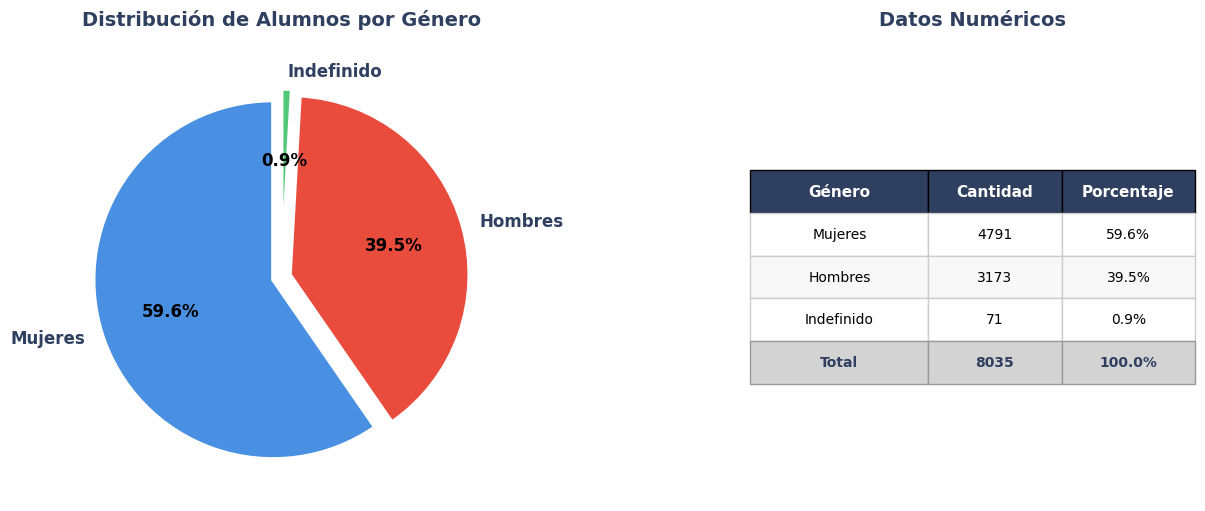

In [ ]:
# 1. DISTRIBUCIÓN POR GÉNERO
dist_genero = df_alumnos['genero'].value_counts().reset_index()
dist_genero.columns = ['Género', 'Cantidad']
dist_genero['Porcentaje'] = (dist_genero['Cantidad'] / dist_genero['Cantidad'].sum() * 100).round(2)

# Crear figura con dos subplots (gráfico + tabla)
fig_genero = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig_genero.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.3)

# --- SUBPLOT 1: Gráfico de Torta ---
ax_pie = fig_genero.add_subplot(gs[0])


# Ajustar colores y explode dinámicamente según la cantidad de categorías
n_categorias = len(dist_genero)
colores_palette = ['#4A90E2', '#E94B3C', '#50C878', '#FFB347', '#9B59B6', '#1ABC9C']
colores = colores_palette[:n_categorias]  # Tomar solo los necesarios
explode = [0.05] * n_categorias  # Crear lista con 0.05 para cada categoría

wedges, texts, autotexts = ax_pie.pie(
    dist_genero['Cantidad'],
    labels=dist_genero['Género'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2.5, 'antialiased': True}
)

# Estilo de los porcentajes (blancos sobre el gráfico)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Estilo de las etiquetas
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2E3F5F')

ax_pie.set_title('Distribución de Alumnos por Género', 
                 fontsize=14, weight='bold', pad=20, color='#2E3F5F')

# --- SUBPLOT 2: Tabla de Datos ---
ax_table = fig_genero.add_subplot(gs[1])
ax_table.axis('off')  # Ocultar ejes

# Preparar datos para la tabla
tabla_data = []
for idx, row in dist_genero.iterrows():
    porcentaje = (row['Cantidad'] / dist_genero['Cantidad'].sum()) * 100
    tabla_data.append([row['Género'], row['Cantidad'], f"{porcentaje:.1f}%"])

# Agregar fila de total
total = dist_genero['Cantidad'].sum()
tabla_data.append(['Total', total, '100.0%'])

# Crear tabla
tabla = ax_table.table(
    cellText=tabla_data,
    colLabels=['Género', 'Cantidad', 'Porcentaje'],
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.3, 0.3]
)

# Estilizar tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2.2)


# Estilo del encabezado
for i in range(3):
    cell = tabla[(0, i)]
    cell.set_facecolor('#2E3F5F')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Estilo de las filas de datos (sin contar total)
for i in range(1, len(tabla_data)):
    for j in range(3):
        cell = tabla[(i, j)]
        cell.set_facecolor('#F8F8F8' if i % 2 == 0 else 'white')
        cell.set_edgecolor('#CCCCCC')

# Fila de total con estilo especial
for j in range(3):
    cell = tabla[(len(tabla_data), j)]
    cell.set_facecolor('#D3D3D3')
    cell.set_text_props(weight='bold', fontsize=10, color='#2E3F5F')
    cell.set_edgecolor('#999999')

ax_table.set_title('Datos Numéricos', 
                   fontsize=14, weight='bold', pad=20, color='#2E3F5F')

plt.show()

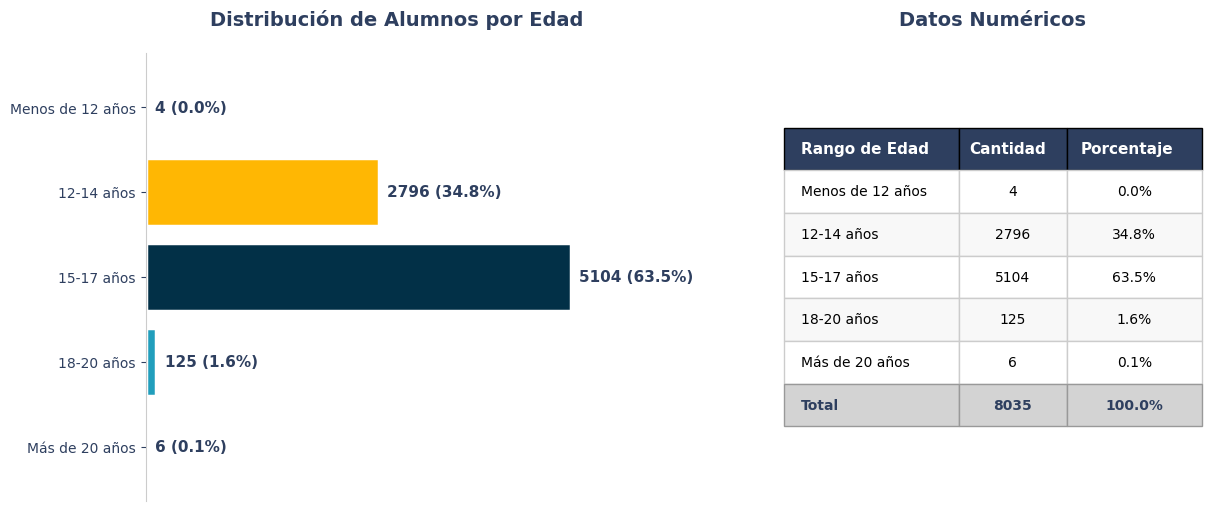

In [ ]:
# 2. DISTRIBUCIÓN POR RANGO DE EDAD
def categorizar_edad(edad):
    if pd.isna(edad):
        return 'Sin información'
    elif edad < 12:
        return 'Menos de 12 años'
    elif 12 <= edad <= 14:
        return '12-14 años'
    elif 15 <= edad <= 17:
        return '15-17 años'
    elif 18 <= edad <= 20:
        return '18-20 años'
    else:
        return 'Más de 20 años'

df_alumnos['rango_edad'] = df_alumnos['edad'].apply(categorizar_edad)


dist_edad = df_alumnos['rango_edad'].value_counts().reset_index()
dist_edad.columns = ['Rango de Edad', 'Cantidad']
dist_edad['Porcentaje'] = (dist_edad['Cantidad'] / dist_edad['Cantidad'].sum() * 100).round(2)

# Ordenar por rango,
orden_edad = ['Menos de 12 años', '12-14 años', '15-17 años', '18-20 años', 'Más de 20 años', 'Sin información']
dist_edad['Rango de Edad'] = pd.Categorical(dist_edad['Rango de Edad'], categories=orden_edad, ordered=True)
dist_edad = dist_edad.sort_values('Rango de Edad')

# 1. Distribución por Edad
fig_edad = crear_grafico_distribucion(
    df_distribucion=dist_edad,
    col_categoria='Rango de Edad',
    col_cantidad='Cantidad',
    titulo_grafico='Distribución de Alumnos por Edad',
    label_y='',
    colormap= ['#8ECAE6', '#219EBC', '#023047', '#FFB703', '#FB8500', '#E8C4A6']

)

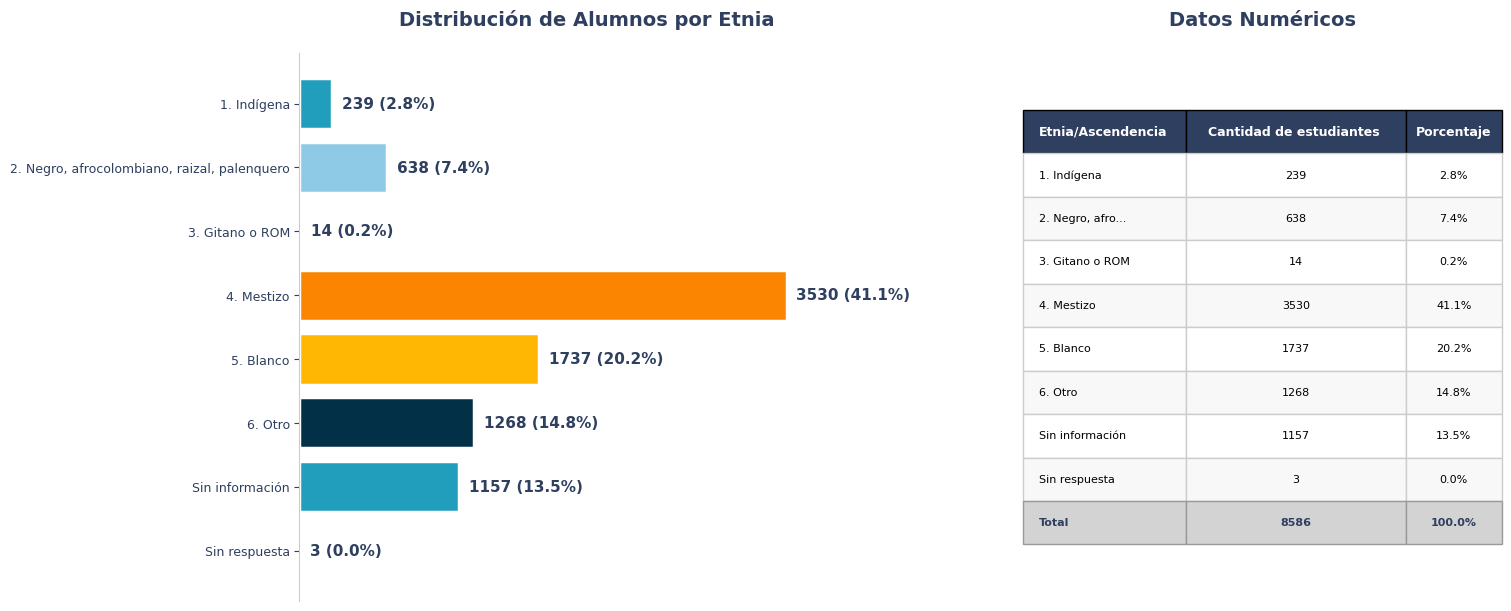

In [181]:
# 4. DISTRIBUCIÓN POR ETNIA/ASCENDENCIA
# Desagregar etnias concatenadas (separadas por |)
def desagregar_etnias(df, columna_etnia='etnia'):
    """
    Desagrega etnias cuando un estudiante tiene múltiples valores separados por |
    """
    # Lista para almacenar los registros desagregados
    registros_desagregados = []
    
    for idx, row in df.iterrows():
        etnia_valor = row[columna_etnia]
        
        # Si el valor es nulo o vacío
        if pd.isna(etnia_valor) or str(etnia_valor).strip() == '':
            registros_desagregados.append({
                'id': row['id'],
                'etnia_individual': 'Sin información'
            })
        else:
            # Separar por | y crear un registro por cada etnia
            etnias = str(etnia_valor).split(';')
            for etnia in etnias:
                etnia_limpia = etnia.strip()
                if etnia_limpia:  # Solo si no está vacío
                    registros_desagregados.append({
                        'id': row['id'],
                        'etnia_individual': etnia_limpia
                    })
    
    return pd.DataFrame(registros_desagregados)

# Desagregar las etnias
df_etnias_desagregadas = desagregar_etnias(df_alumnos)

# Calcular distribución
dist_etnia = df_etnias_desagregadas['etnia_individual'].value_counts().reset_index()
dist_etnia.columns = ['Etnia/Ascendencia', 'Cantidad de estudiantes']
dist_etnia=dist_etnia.sort_values('Etnia/Ascendencia')

# Calcular porcentaje sobre el total de estudiantes únicos
total_estudiantes = df_alumnos['id'].nunique()
dist_etnia['Porcentaje (sobre total estudiantes)'] = (dist_etnia['Cantidad de estudiantes'] / total_estudiantes * 100).round(2)

# grafico
fig_etnia = crear_grafico_distribucion(
    df_distribucion=dist_etnia,
    col_categoria='Etnia/Ascendencia',
    col_cantidad='Cantidad de estudiantes',
    titulo_grafico='Distribución de Alumnos por Etnia',
    label_y='',
    colormap=['#8ECAE6', '#219EBC', '#023047', '#FFB703', '#FB8500', '#E8C4A6'],
    truncar_categorias=True
)

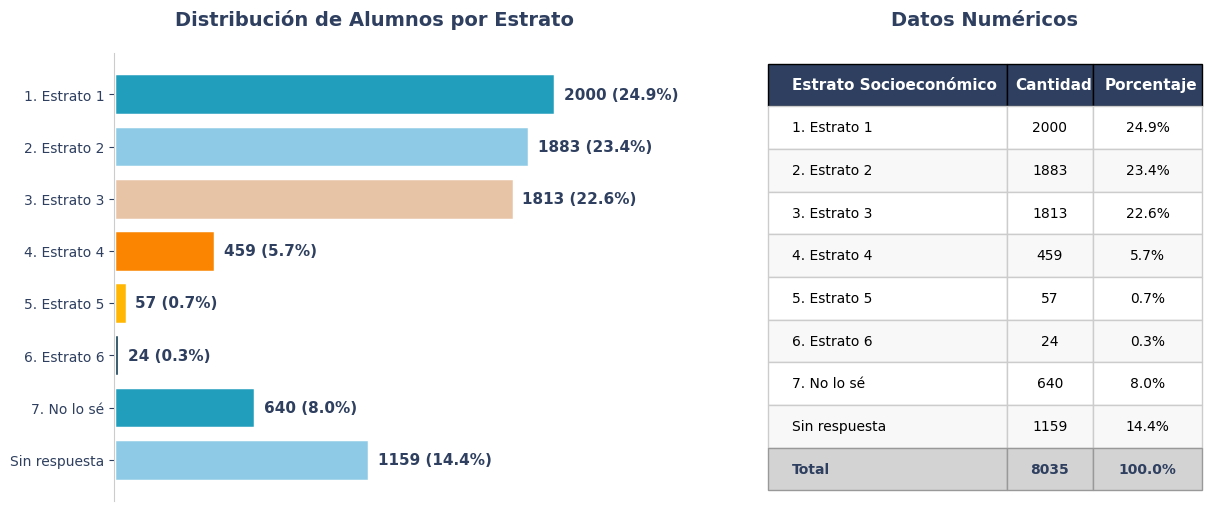

In [182]:
# 3. DISTRIBUCIÓN POR ESTRATO SOCIOECONÓMICO
dist_estrato = df_alumnos['estrato_socioeconomico'].value_counts().reset_index()
dist_estrato.columns = ['Estrato Socioeconómico', 'Cantidad']
dist_estrato['Porcentaje'] = (dist_estrato['Cantidad'] / dist_estrato['Cantidad'].sum() * 100).round(2)
dist_estrato = dist_estrato.sort_values('Estrato Socioeconómico')

fig_estrato = crear_grafico_distribucion(
    df_distribucion=dist_estrato,
    col_categoria='Estrato Socioeconómico',
    col_cantidad='Cantidad',
    titulo_grafico='Distribución de Alumnos por Estrato',
    label_y='',
    colormap=['#8ECAE6', '#219EBC', '#023047', '#FFB703', '#FB8500', '#E8C4A6'],
    truncar_categorias=True
)

In [184]:
# ============================================================================
# GENERACIÓN DE DOCUMENTO WORD CON WORD.PY
# ============================================================================

import word

# Crear el documento usando DocumentBuilder
builder = word.DocumentBuilder()

# Agregar título general del documento
builder.titulo("INFORME DE ANÁLISIS DEMOGRÁFICO DEL PROYECTO", nivel=1)

# Agregar introducción al proyecto
builder.titulo("Introducción al proyecto", nivel=2)

builder.parrafo(
    "Este documento presenta un análisis demográfico completo de los estudiantes "
    "participantes en el proyecto. A continuación se muestran las distribuciones "
    "por género, edad y estrato socioeconómico, elementos clave para comprender "
    "el perfil de la población atendida y orientar estrategias pedagógicas inclusivas."
)

# Sección: Distribución por Género
builder.titulo("Distribución por Género", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de estudiantes según su género. "
    "Este indicador permite evaluar la equidad de acceso al programa y diseñar "
    "estrategias de inclusión cuando sea necesario."
)
builder.figura(fig_genero, pie="Figura 1: Distribución de estudiantes por género")

# Sección: Distribución por Edad
builder.titulo("Distribución por Edad", nivel=3)
builder.parrafo(
    "El análisis por rangos etarios permite identificar los grupos de edad predominantes "
    "en el proyecto. Esta información es fundamental para ajustar contenidos, metodologías "
    "y dinámicas de aprendizaje según el nivel de desarrollo de los participantes."
)
builder.figura(fig_edad, pie="Figura 2: Distribución de estudiantes por rango de edad")

# Sección: Distribución por Estrato Socioeconómico
builder.titulo("Distribución por Estrato Socioeconómico", nivel=3)
builder.parrafo(
    "La distribución por estrato socioeconómico refleja el contexto económico de los estudiantes. "
    "Este dato es relevante para comprender barreras de acceso tecnológico, diseñar políticas de apoyo "
    "y evaluar el impacto social del proyecto en poblaciones vulnerables."
)
builder.figura(fig_estrato, pie="Figura 3: Distribución de estudiantes por estrato socioeconómico")
builder.numerar_titulos()

# Guardar el documento
ruta_salida = "informe_demografico_proyecto.docx"
builder.guardar(ruta_salida, verbose=True)

print(f"\n✅ Documento generado exitosamente: {ruta_salida}")


[OK] Documento guardado en: informe_demografico_proyecto.docx
[OK] Operaciones realizadas: 13

✅ Documento generado exitosamente: informe_demografico_proyecto.docx
